In [1]:
import numpy as np
import pandas as pd
import warnings
import urllib
import seaborn as sns
import matplotlib
from matplotlib.patches import FancyArrow
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects
from mplsoccer import Pitch, VerticalPitch, lines
from tqdm import tqdm

from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import image

import socceraction
import socceraction.atomic.spadl as atomicspadl
import socceraction.spadl as spadl
from PIL import Image
import io

/Users/davidegualano/anaconda3/envs/Socceraction/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
fe = fm.FontEntry(
    fname='/Users/davidegualano/Documents/Python FTBLData/SourceSansPro-Regular.ttf',
    name='SourceSansPro-Regular'
)
fm.fontManager.ttflist.insert(0, fe)
matplotlib.rcParams['font.family'] = fe.name

In [3]:
VAEP = pd.read_csv("aVAEPactions.csv", index_col = 0)
xP = pd.read_csv("xPactions.csv", index_col = 0)
fb = pd.read_csv("teamsFOTMOB.csv", index_col = 0)

In [4]:
players0 = pd.read_csv("players2021.csv", index_col = 0)
players1 = pd.read_csv("players2122.csv", index_col = 0)
players2 = pd.read_csv("players2223.csv", index_col = 0)
players3 = pd.read_csv("players2324.csv", index_col = 0)

games0 = pd.read_csv("games2021.csv", index_col = 0)
games1 = pd.read_csv("games2122.csv", index_col = 0)
games2 = pd.read_csv("games2223.csv", index_col = 0)
games3 = pd.read_csv("games2324.csv", index_col = 0)

recoveries0 = pd.read_csv("recoveries_id2021.csv", index_col = 0)
recoveries1 = pd.read_csv("recoveries_id2122.csv", index_col = 0)
recoveries2 = pd.read_csv("recoveries_id2223.csv", index_col = 0)
recoveries3 = pd.read_csv("recoveries_id2324.csv", index_col = 0)

In [5]:
PADJ0 = pd.read_csv("PADJ2021.csv", index_col = 0)
PADJ1 = pd.read_csv("PADJ2122.csv", index_col = 0)
PADJ2 = pd.read_csv("PADJ2223.csv", index_col = 0)
PADJ3 = pd.read_csv("PADJ2324.csv", index_col = 0)

In [6]:
aactions0 = pd.read_csv("atomic_actions2021.csv", index_col = 0)
aactions1 = pd.read_csv("atomic_actions2122.csv", index_col = 0)
aactions2 = pd.read_csv("atomic_actions2223.csv", index_col = 0)
aactions3 = pd.read_csv("atomic_actions2324.csv", index_col = 0)

actions0 = pd.read_csv("actions2021.csv", index_col = 0)
actions1 = pd.read_csv("actions2122.csv", index_col = 0)
actions2 = pd.read_csv("actions2223.csv", index_col = 0)
actions3 = pd.read_csv("actions2324.csv", index_col = 0)

In [7]:
players = pd.concat([players0, players1, players2, players3])
games = pd.concat([games0, games1, games2, games3])
recoveries = pd.concat([recoveries0, recoveries1, recoveries2, recoveries3])
PADJ = pd.concat([PADJ0, PADJ1, PADJ2, PADJ3])
aactions = pd.concat([aactions0, aactions1, aactions2, aactions3])
actions = pd.concat([actions0, actions1, actions2, actions3])

In [8]:
recoveries.reset_index(drop=True, inplace=True)
recoveries.rename(columns = {'type_name':'qualifier'}, inplace = True)
recoveries.rename(columns = {'event_id':'original_event_id'}, inplace = True)

In [9]:
aactions.drop(columns=['action_id'], inplace=True)
aactions.reset_index(drop=True, inplace=True)
aactions.reset_index(inplace=True)
aactions.rename(columns={'index': 'action_id'}, inplace=True)

In [10]:
actions.drop(columns=['action_id'], inplace=True)
actions.reset_index(drop=True, inplace=True)
actions.reset_index(inplace=True)
actions.rename(columns={'index': 'action_id'}, inplace=True)

In [11]:
aactions = atomicspadl.add_names(aactions)

In [12]:
actions = spadl.add_names(actions)

In [13]:
def convert_to_seconds(time_str):
    try:
        # Convert to string in case it's a float (e.g., NaN)
        time_str = str(time_str)
        # Split the time string into minutes and seconds
        minutes, seconds = map(int, time_str.split(':'))
        # Convert total time to seconds (minutes converted to seconds)
        return minutes * 60 + seconds
    except (ValueError, AttributeError):
        # Handle cases where the conversion fails (e.g., NaN or bad format)
        return 0  # or use `np.nan` if you prefer to mark as missing

# Apply the conversion function to the 'minutes_played' column
players['seconds_played'] = players['minutes_played'].apply(convert_to_seconds)
players['start_second'] = players['start_second'].apply(convert_to_seconds)
players['end_second'] = players['end_second'].apply(convert_to_seconds)

In [14]:
dfa = (
    aactions
    .merge(players, how="left")
    .merge(fb, how="left")
    .merge(VAEP, how="left"))

In [15]:
dfb = (actions
       .merge(players, how="left")
       .merge(fb, how="left"))

In [16]:
dfb["beginning_distance"] = np.sqrt(np.square(105-dfb['start_x_a0']) + np.square(34-dfb['start_y_a0'])).round(2)
dfb["end_distance"] = np.sqrt(np.square(105-dfb['end_x_a0']) + np.square(34-dfb['end_y_a0'])).round(2)
dfb["length"] = dfb["end_distance"] - dfb["beginning_distance"]
dfb['length'] = dfb['length'].abs()
dfb["angle"] = np.arctan2(dfb["end_y_a0"] - dfb["start_y_a0"], dfb["end_x_a0"] - dfb["start_x_a0"])
dfb['angle_degrees'] = np.degrees(dfb['angle']) % 360

In [17]:
dfb["next_type_name"] = dfb.shift(-1, fill_value=0)["type_name"]
dfb["next_player_name"] = dfb.shift(-1, fill_value=0)["player_name"]
dfb["next_team_name"] = dfb.shift(-1, fill_value=0)["team_name"]

In [18]:
dfb.type_name.unique()

array(['pass', 'dribble', 'interception', 'throw_in', 'clearance',
       'take_on', 'tackle', 'corner_crossed', 'shot', 'freekick_crossed',
       'bad_touch', 'keeper_pick_up', 'foul', 'keeper_save', 'cross',
       'freekick_short', 'goalkick', 'keeper_claim', 'corner_short',
       'keeper_punch', 'shot_freekick', 'shot_penalty'], dtype=object)

In [19]:
def_actions = dfb[dfb["type_name"].isin(['interception', 'clearance', 'tackle', 'foul', 'dribble'])]
dfaa = dfa[dfa["type_name"].isin(['interception', 'clearance', 'tackle', 'foul', 'dribble'])]

In [20]:
# Remove rows where 'original_event_id' is NaN in both DataFrames
def_actions = def_actions.dropna(subset=['original_event_id'])
def_actions['original_event_id'] = def_actions['original_event_id'].astype(int)
dfaa = dfaa.dropna(subset=['original_event_id'])

In [21]:
fa = dfaa.filter(items=['game_id', 'original_event_id', 'team_id', 'offensive_value', 'defensive_value', 'vaep_value'])

In [22]:
def_actions['is_recovery'] = def_actions['original_event_id'].isin(recoveries['original_event_id'])
fa['original_event_id'] = fa['original_event_id'].astype(int)

In [23]:
def_actions = def_actions.merge(fa, how="left")

In [24]:
def_actions = def_actions[~((def_actions['type_name'] == 'dribble') & (def_actions['is_recovery'] == False))]

In [25]:
def format_season_id(season_id):
    # Convert to integer if it's a float
    season_id = int(season_id)
    # Extract the last two digits of the year
    start_year = str(season_id -1)[-2:]
    # Calculate the end year
    end_year = str(season_id)[-2:]
    # Format as 20/21
    formatted_season = f"{start_year}/{end_year}"
    return formatted_season

In [26]:
playerlist = def_actions['player_name'].unique().tolist()
cleaned_playerlist = [name for name in playerlist if pd.notna(name)]
cleaned_playerlist.sort()

In [27]:
from IPython.display import display, HTML

# Step 3: Generate the HTML dropdown
options_html = ''.join([f'<option value="{name}">{name}</option>' for name in cleaned_playerlist])

dropdown_html = f"""
<input list="players" id="dropdown" oninput="handleInput()" placeholder="Choose Someone">
<datalist id="players">
    {options_html}
</datalist>
<p id="output"></p>
<script>
function handleInput() {{
    var input = document.getElementById("dropdown").value;
    var output = document.getElementById("output");
    output.innerHTML = "Selected: " + input;
}}
</script>
"""

# Display the dropdown
display(HTML(dropdown_html))

In [78]:
P0 = def_actions[def_actions["player_name"] == 'Manuel Ugarte']
P0.team_name.unique()

array(['Famalicao', 'Sporting', 'PSG'], dtype=object)

In [86]:
P1 = P0[P0["team_name"] == "PSG"]

In [87]:
P1['formatted_season'] = P1['season_id'].apply(format_season_id)
P1.season_id.unique()

/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_11240/438652562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P1['formatted_season'] = P1['season_id'].apply(format_season_id)


array([2324.])

In [88]:
P = P1[P1['season_id'].isin([2324.])]

In [89]:
# Calculate mean and standard deviation for the column
mean_y = P['start_y_a0'].mean()
std_dev_y = P['start_y_a0'].std()
mean_x = P['start_x_a0'].mean()
std_dev_x = P['start_x_a0'].std()

# Define the range for one standard deviation
lower_bound_y = mean_y - (std_dev_y*1)
upper_bound_y = mean_y + (std_dev_y*1)
lower_bound_x = mean_x - (std_dev_x*1)
upper_bound_x = mean_x + (std_dev_x*1)

# Filter the DataFrame to include only the values within one standard deviation
filtered_df = P[(P['start_y_a0'] >= lower_bound_y) & (P['start_y_a0'] <= upper_bound_y)]
filtered_df = filtered_df[(filtered_df['start_x_a0'] >= lower_bound_x) & (filtered_df['start_x_a0'] <= upper_bound_x)]

In [90]:
grouped_df = def_actions.groupby(["defensive_value"], observed=True)['defensive_value'].count().reset_index(name='count')

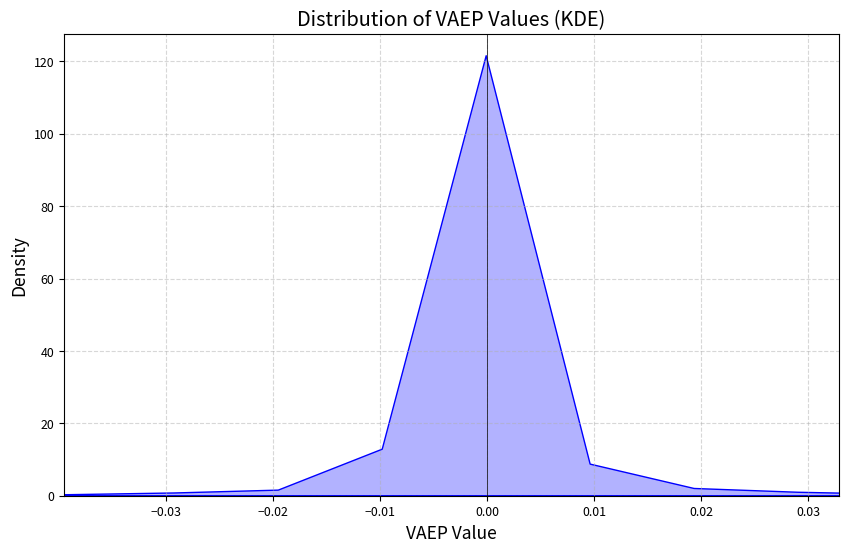

In [91]:
# Ensure the 'vaep_value' column is numeric
grouped_df['defensive_value'] = pd.to_numeric(grouped_df['defensive_value'], errors='coerce')

# Function to determine x-axis limits based on percentiles
def determine_x_limits(data, lower_percentile=1, upper_percentile=99):
    lower_limit = data.quantile(lower_percentile / 100)
    upper_limit = data.quantile(upper_percentile / 100)
    return lower_limit, upper_limit

# Determine the x-axis limits
x_min, x_max = determine_x_limits(grouped_df['defensive_value'])

# Generate KDE plot using the 'vaep_value' values (ignoring 'count' since KDE is univariate)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=grouped_df['defensive_value'], bw_adjust=0.5, fill=True, color='blue', alpha=0.3)

# Add titles and labels
plt.title('Distribution of VAEP Values (KDE)', fontsize=16)
plt.xlabel('VAEP Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Set the x-axis limits based on the determined values
plt.xlim(x_min, x_max)

# Customize the plot style
plt.grid(False, linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Show the plot
plt.show()

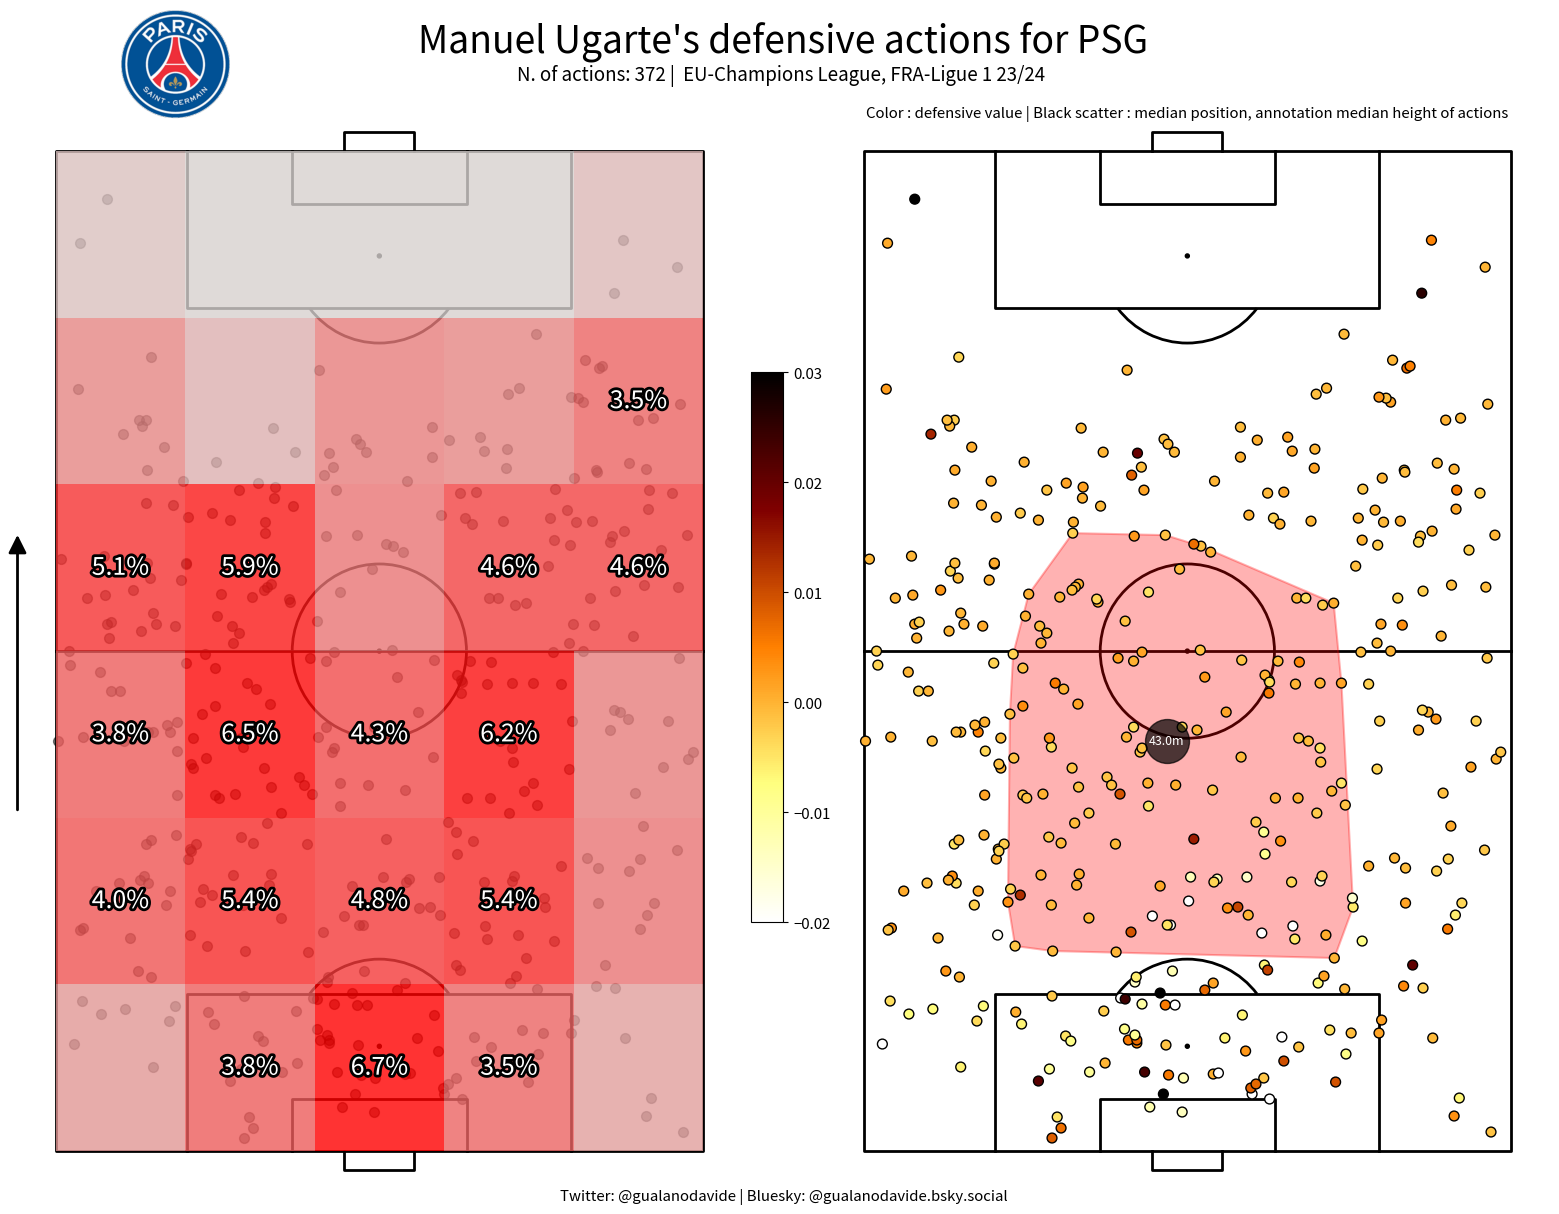

In [92]:
nrows = P.shape[0]
for y in range(nrows):
    title = P['player_name'].iloc[y]
    titlex = P['season_id'].iloc[y]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 11), constrained_layout=True)
# Adjust padding for constrained layout
fig.set_constrained_layout_pads(h_pad=0.08, w_pad=0)

# Define the vertical pitch parameters
pitch = VerticalPitch(pitch_type='custom', pitch_width=68, pitch_length=105, goal_type='box', linewidth=2, line_color='black', half=False)
# Define colormap for the heatmap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_red", ["#D7D1CF", "#FF0000"])
### First Plot - ax1 ###
pitch.draw(ax=ax1)
# Compute bin statistics for the first heatmap
bins = (6, 5)
bs_heatmap_1 = pitch.bin_statistic(P.start_x_a0, P.start_y_a0, statistic='count', bins=bins)
# Plot heatmap and scatter for the first plot
hm1 = pitch.heatmap(bs_heatmap_1, ax=ax1, cmap=cmap, zorder=3, alpha=0.8)
scatter1 = pitch.scatter(P.start_x_a0, P.start_y_a0, ax=ax1, edgecolor='#000000', facecolor='#000000', s=50, alpha=0.5)

# Annotate each bin with the percentage of passes for the first plot
total_passes_1 = bs_heatmap_1['statistic'].sum()  # Total number of passes
for i in range(bs_heatmap_1['statistic'].shape[0]):
    for j in range(bs_heatmap_1['statistic'].shape[1]):
        count = bs_heatmap_1['statistic'][i, j]
        if count > 0:  # Annotate only non-empty bins
            percentage = (count / total_passes_1) * 100
            if percentage > 3:  # Only annotate if the percentage is greater than 3%
                bin_center_x = bs_heatmap_1['cy'][i, j]  # Correct center coordinates for VerticalPitch
                bin_center_y = bs_heatmap_1['cx'][i, j]
                text = ax1.text(bin_center_x, bin_center_y, f"{percentage:.1f}%", color="#FFFFFF", ha="center", va="center",
                                fontsize=20, zorder=4)
                # Add path effects for the edge
                text.set_path_effects([path_effects.Stroke(linewidth=4, foreground='#000000'),
                                       path_effects.Normal()])
                
# Annotation with data coordinates and offset points for the second plot
ax1.annotate(text="", xy=(72, 65), xytext=(0, -200), textcoords="offset points", size=27, color="#000000", 
             arrowprops=dict(arrowstyle="-|>", shrinkA=0, color="black", linewidth=2))

cmap = matplotlib.colormaps.get_cmap('afmhot_r')
vmin = -0.02  # or set manually, e.g., vmin = 0
vmax = 0.03  # or set manually, e.g., vmax = 1
# Normalize the data to the specified range
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
# Apply the colormap and normalization to your data
colors = cmap(norm(P['defensive_value']))

# Create and customize the colorbar
cbar_ax = fig.add_axes([.48, 0.25, 0.02, 0.5])  # Adjust position and size of colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set the array for the ScalarMappable
cbar = plt.colorbar(sm, cax=cbar_ax)
# Add title to the colorbar
cbar.ax.set_title('', fontsize=25, pad=20, rotation=0, loc='center')
# Adjust font size of the colorbar tick labels
cbar.ax.tick_params(labelsize=12)

### Second Plot - ax2 ###
pitch.draw(ax=ax2)
# Create the convexhull
hull = pitch.convexhull(filtered_df.start_x_a0, filtered_df.start_y_a0)
poly = pitch.polygon(hull, ax=ax2, edgecolor='#FF0000', facecolor='#FF0000', alpha=0.3, linewidth=1.5)
scatter = pitch.scatter(P.start_x_a0, P.start_y_a0, ax=ax2, edgecolor='#000000', facecolor=colors, s=50)
scatter2 = pitch.scatter(P['start_x_a0'].median(), P['start_y_a0'].median(), ax=ax2, edgecolor='#000000', facecolor='#000000', s=1000, alpha=0.7)
# Add annotation inside the scatter point
ax2.text(P['start_y_a0'].median(), P['start_x_a0'].median(), f"{P['start_x_a0'].median():.1f}m", color='#FFFFFF', fontsize=10,
    ha='center', va='center')

ax2.text(34, 109, f'Color : defensive value | Black scatter : median position, annotation median height of actions', fontsize=12, va='center', ha='center')

### Add a Single Set of Text Annotations for Both Plots ###
fig.text(0.5, 1.05, f"{P.player_name.iloc[0]}'s defensive actions for {P.team_name.iloc[0]}", fontsize=30, va='center', ha='center')
fig.text(0.5, 1.02, f"N. of actions: {P['type_name'].count()} |  {', '.join(P['competition_id'].unique())} {', '.join(P['formatted_season'].unique())} ", fontsize=15, va='center', ha='center')
fig.text(0.5, 0.001, f'Twitter: @gualanodavide | Bluesky: @gualanodavide.bsky.social', fontsize=12, va='center', ha='center')

fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
logo_ax = fig.add_axes([.07, 0.98, 0.1, 0.1], zorder=1)
club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{P['fotmob_id'].iloc[0]}.png"))
logo_ax.imshow(club_icon)
logo_ax.axis("off")

# Save the figure with adjusted face color and transparency
plt.savefig(f'{title}defensiveactions-{titlex}.png', dpi=500, facecolor="#D7D1CF", bbox_inches="tight", transparent=True)
plt.show()


In [44]:
# Calculate median of start_x_a0
depth0 = def_actions.copy()

# Determine if values are above or below the median
depth0['above'] = depth0['start_x_a0'] >= 52.5
depth0['below'] = depth0['start_x_a0'] < 52.5

# Count instances above and below the median
depth0a = depth0[depth0['above'] == True]
depth1 = depth0a.groupby(["player_id", "player_name", "team_name"])['above'].sum().reset_index(name='count_above')
depth0b = depth0[depth0['below'] == True]
depth2 = depth0b.groupby(["player_id", "player_name", "team_name"])['below'].sum().reset_index(name='count_below')

depth3 = depth0.groupby(["player_id", "player_name", "team_name"])['type_name'].count().reset_index(name='count')

# Merge results
deptha = depth1.merge(depth2, on=["player_id", "player_name", "team_name"], how='left')
depth = deptha.merge(depth3, on=["player_id", "player_name", "team_name"], how='left')
depth = depth.fillna(0)
depth['count_above'] = ((depth['count_above']*100)/depth['count']).round(2)
depth['count_below'] = ((depth['count_below']*100)/depth['count']).round(2)
depth['depth'] = depth['count_above'] - depth['count_below']

depth = depth.filter(items=["player_id", "player_name", "team_name", "depth"])

In [45]:
activeness0a = def_actions[def_actions["type_name"].isin(['interception', 'tackle'])]
activeness0 = activeness0a.groupby(["player_id", "player_name", "team_name"])['type_name'].count().reset_index(name='count_proactive')

activeness1a = def_actions[def_actions["type_name"].isin(['clearance', 'dribble'])]
activeness1 = activeness1a.groupby(["player_id", "player_name", "team_name"])['type_name'].count().reset_index(name='count_reactive')

activeness = activeness0.merge(activeness1, on=["player_id", "player_name", "team_name"], how='left')
activeness['aggressiveness'] = (activeness['count_proactive'] / activeness['count_reactive']).round(2)
# Replace NaN values with 0
activeness = activeness.fillna(0)

activeness = activeness.filter(items=["player_id", "player_name", "team_name", "aggressiveness"])

In [46]:
tackle0a = def_actions[def_actions["type_name"].isin(['tackle'])]
tackle0 = tackle0a.groupby(["player_id", "player_name", "team_name"])['type_name'].count().reset_index(name='count_tackle')

tackle1a = tackle0a[tackle0a["result_name"] == 'fail']
tackle1 = tackle1a.groupby(["player_id", "player_name", "team_name"])['type_name'].count().reset_index(name='count_fails')

tackle2a = tackle0a[(tackle0a["next_type_name"] == 'foul') & (tackle0a["player_name"] == tackle0a["next_player_name"])]
tackle2 = tackle2a.groupby(["player_id", "player_name", "team_name"])['type_name'].count().reset_index(name='count_foul')

# Merge tackle0 with tackle1 using a left join
tacklea = tackle0.merge(tackle1, on=["player_id", "player_name", "team_name"], how='left')
# Merge the result with tackle2 also using a left join
tackle = tacklea.merge(tackle2, on=["player_id", "player_name", "team_name"], how='left')
# Replace NaN values with 0
tackle = tackle.fillna(0)

tackle['tackles_win_rate'] = ((tackle['count_tackle'] - (tackle['count_fails'] + tackle['count_foul'])) / tackle['count_tackle']).round(2)
tackle = tackle.filter(items=["player_id", "player_name", "team_name", "tackles_win_rate"])

In [47]:
dactions0a = def_actions.groupby(["player_id", "player_name", "team_name", "game_id"])['type_name'].count().reset_index(name='count_def_actions')
dactions0 = dactions0a.groupby(["player_id", "player_name", "team_name"])['count_def_actions'].sum().reset_index(name='def_actions')

playersX = (players.merge(fb, how="left"))
dactions1a = playersX.groupby(["player_id", "player_name", "team_name", "game_id"])['seconds_played'].sum().reset_index(name='seconds_played')
dactions1 = dactions1a.groupby(["player_id", "player_name", "team_name"])['seconds_played'].sum().reset_index(name='seconds_played')
dactions1['minutes_played'] = (dactions1['seconds_played']/60).round(2)
dactions1 = dactions1.filter(items=["player_id", "player_name", "team_name", "minutes_played"])

dactions2 = PADJ.groupby(["player_id", "player_name", "team_name"])['actions_against'].sum().reset_index(name='actions_against')

dactions3a = def_actions.groupby(["player_id", "player_name", "team_name", "game_id"])['defensive_value'].sum().reset_index(name='defensive_value')
dactions3 = dactions3a.groupby(["player_id", "player_name", "team_name"])['defensive_value'].sum().reset_index(name='defensive_value')

dactions4a = def_actions.groupby(["player_id", "player_name", "team_name", "game_id"])['vaep_value'].sum().reset_index(name='vaep_value')
dactions4 = dactions4a.groupby(["player_id", "player_name", "team_name"])['vaep_value'].sum().reset_index(name='vaep_value')

dactionsa = dactions0.merge(dactions1, on=["player_id", "player_name", "team_name"], how='left')
dactionsb = dactionsa.merge(dactions2, on=["player_id", "player_name", "team_name"], how='left')
dactionsc = dactionsb.merge(dactions3, on=["player_id", "player_name", "team_name"], how='left')
dactions = dactionsc.merge(dactions4, on=["player_id", "player_name", "team_name"], how='left')
dactions = dactions.fillna(0)

dactions['activity'] = ( (586.5478817286353 * dactions['def_actions'])/dactions['actions_against'] ).round(2)
dactions["defensive_rating"] = dactions.defensive_value * 90 / dactions.minutes_played
dactions["vaep_rating"] = dactions.vaep_value * 90 / dactions.minutes_played
dactions = dactions.filter(items=["player_id", "player_name", "team_name", "minutes_played", "activity", "vaep_rating", "defensive_rating"])

In [48]:
playersY = playersX.merge(PADJ)
F = playersY[playersY['minutes_played'] == playersY['game_duration']]
F1 = F[F['end_period'] <= 2]
F1.actions_against.mean()

586.5478817286353

In [49]:
defensea = depth.merge(activeness, on=["player_id", "player_name", "team_name"], how='left')
defenseb = defensea.merge(tackle, on=["player_id", "player_name", "team_name"], how='left')
defense = defenseb.merge(dactions, on=["player_id", "player_name", "team_name"], how='left')

defense = defense[defense['minutes_played'] >= 1000]

In [50]:
player_names = ['Casemiro', 'Éderson', 'Manuel Ugarte', 'Frenkie de Jong', 'Edson Álvarez', 'Rodri', 'Ryan Gravenberch', 'Carlos Baleba',
                'Moisés Caicedo', 'Declan Rice', 'Bruno Guimarães', 'Sandro Tonali', 'André', 'Thomas Partey', 'Wataru Endo']

Cc = defense[defense['player_name'].isin(player_names)]
Cc = Cc.merge(fb)

In [51]:
CC = Cc[['fotmob_id', 'player_name', 'minutes_played', 'activity',  'tackles_win_rate', 'aggressiveness', 'depth', 
    'vaep_rating', 'defensive_rating']]

CC['minutes_played'] = CC['minutes_played'].round(0)
CC['activity'] = CC['activity'].round(2)
CC['tackles_win_rate'] = (CC['tackles_win_rate']*100).round(0)
CC['aggressiveness'] = CC['aggressiveness'].round(2)
CC['depth'] = CC['depth'].round(2)
CC['vaep_rating'] = CC['vaep_rating'].round(3)
CC['defensive_rating'] = CC['defensive_rating'].round(3)

CC = CC.rename(columns={
    'player_name': 'Player',
    'minutes_played': 'Minutes Played',
    'activity': 'Def Actions PADJ',
    'tackles_win_rate': 'Tackles W Rate',
    'aggressiveness': 'Aggression',
    'depth': 'Depth',
    'vaep_rating': 'Vaep',
    'defensive_rating': 'Defensive'
})

CC =  CC.sort_values("Def Actions PADJ", ascending=False)

/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_11240/1021997544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CC['minutes_played'] = CC['minutes_played'].round(0)
/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_11240/1021997544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CC['activity'] = CC['activity'].round(2)
/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_11240/1021997544.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [52]:
def load_image(fotmob_id):
    try:
        url = f"{fotmob_url}{fotmob_id}.png"
        image = Image.open(urllib.request.urlopen(url))
        return image
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

def plot_image(ax, fotmob_id, **kwargs):
    image = load_image(fotmob_id)
    if image:
        ax.imshow(image)
        ax.axis('off')

In [66]:
# Create ColumnDefinitions for the table
# I'll show you how to do 3 things the columns
# 1. load images
# 2. add color
# 3. add columns to groups
plt.rcParams["text.color"] = "#000000"
cmap = mcolors.LinearSegmentedColormap.from_list("custom_red", ["#00FFFF", "#000050"])

col_defs = [
    ColumnDefinition(
        name="fotmob_id",
        textprops={"ha": "center", "va": "center", 'color': "#D7D1CF"},
        width=0.5,
        plot_fn=plot_image,
    ),
    ColumnDefinition(
        name="Player",
        textprops={"ha": "left"},
        width=0.7,
    ),
    ColumnDefinition(
        name="Minutes Played",
        textprops={"ha": "center"},
        width=0.5,
    ),
    ColumnDefinition(
        name="Def Actions PADJ",
        textprops={"ha": "center"},
        width=0.5,
    ),
    ColumnDefinition(
        name="Tackles W Rate",
        textprops={"ha": "center"},
        width=0.5,
    ),
    ColumnDefinition(
        name="Aggression",
        group="Index",
        textprops={"ha": "center", "color": "#000000", "bbox": {"boxstyle": "circle", "pad": 0.2}},
        cmap=normed_cmap(CC["Aggression"], cmap=matplotlib.cm.afmhot_r, num_stds=1,),
        width=0.5,
    ),
    ColumnDefinition(
        name="Depth",
        group="Index",
        textprops={"ha": "center", "color": "#000000", "bbox": {"boxstyle": "circle", "pad": 0.2}},
        cmap=normed_cmap(CC["Depth"], cmap=matplotlib.cm.afmhot_r, num_stds=1,),
        width=0.5,
    ),
    ColumnDefinition(
        name="Vaep",
        group="Ratings",
        textprops={"ha": "center", "color": "#000000", "bbox": {"boxstyle": "circle", "pad": 0.2}},
        cmap=normed_cmap(CC["Vaep"], cmap=matplotlib.cm.afmhot_r, num_stds=1,),
        width=0.5,
    ),
    ColumnDefinition(
        name="Defensive",
        group="Ratings",
        textprops={"ha": "center", "color": "#000000", "bbox": {"boxstyle": "circle", "pad": 0.2}},
        cmap=normed_cmap(CC["Defensive"], cmap=matplotlib.cm.afmhot_r, num_stds=1,),
        width=0.5,
    ),
   
]

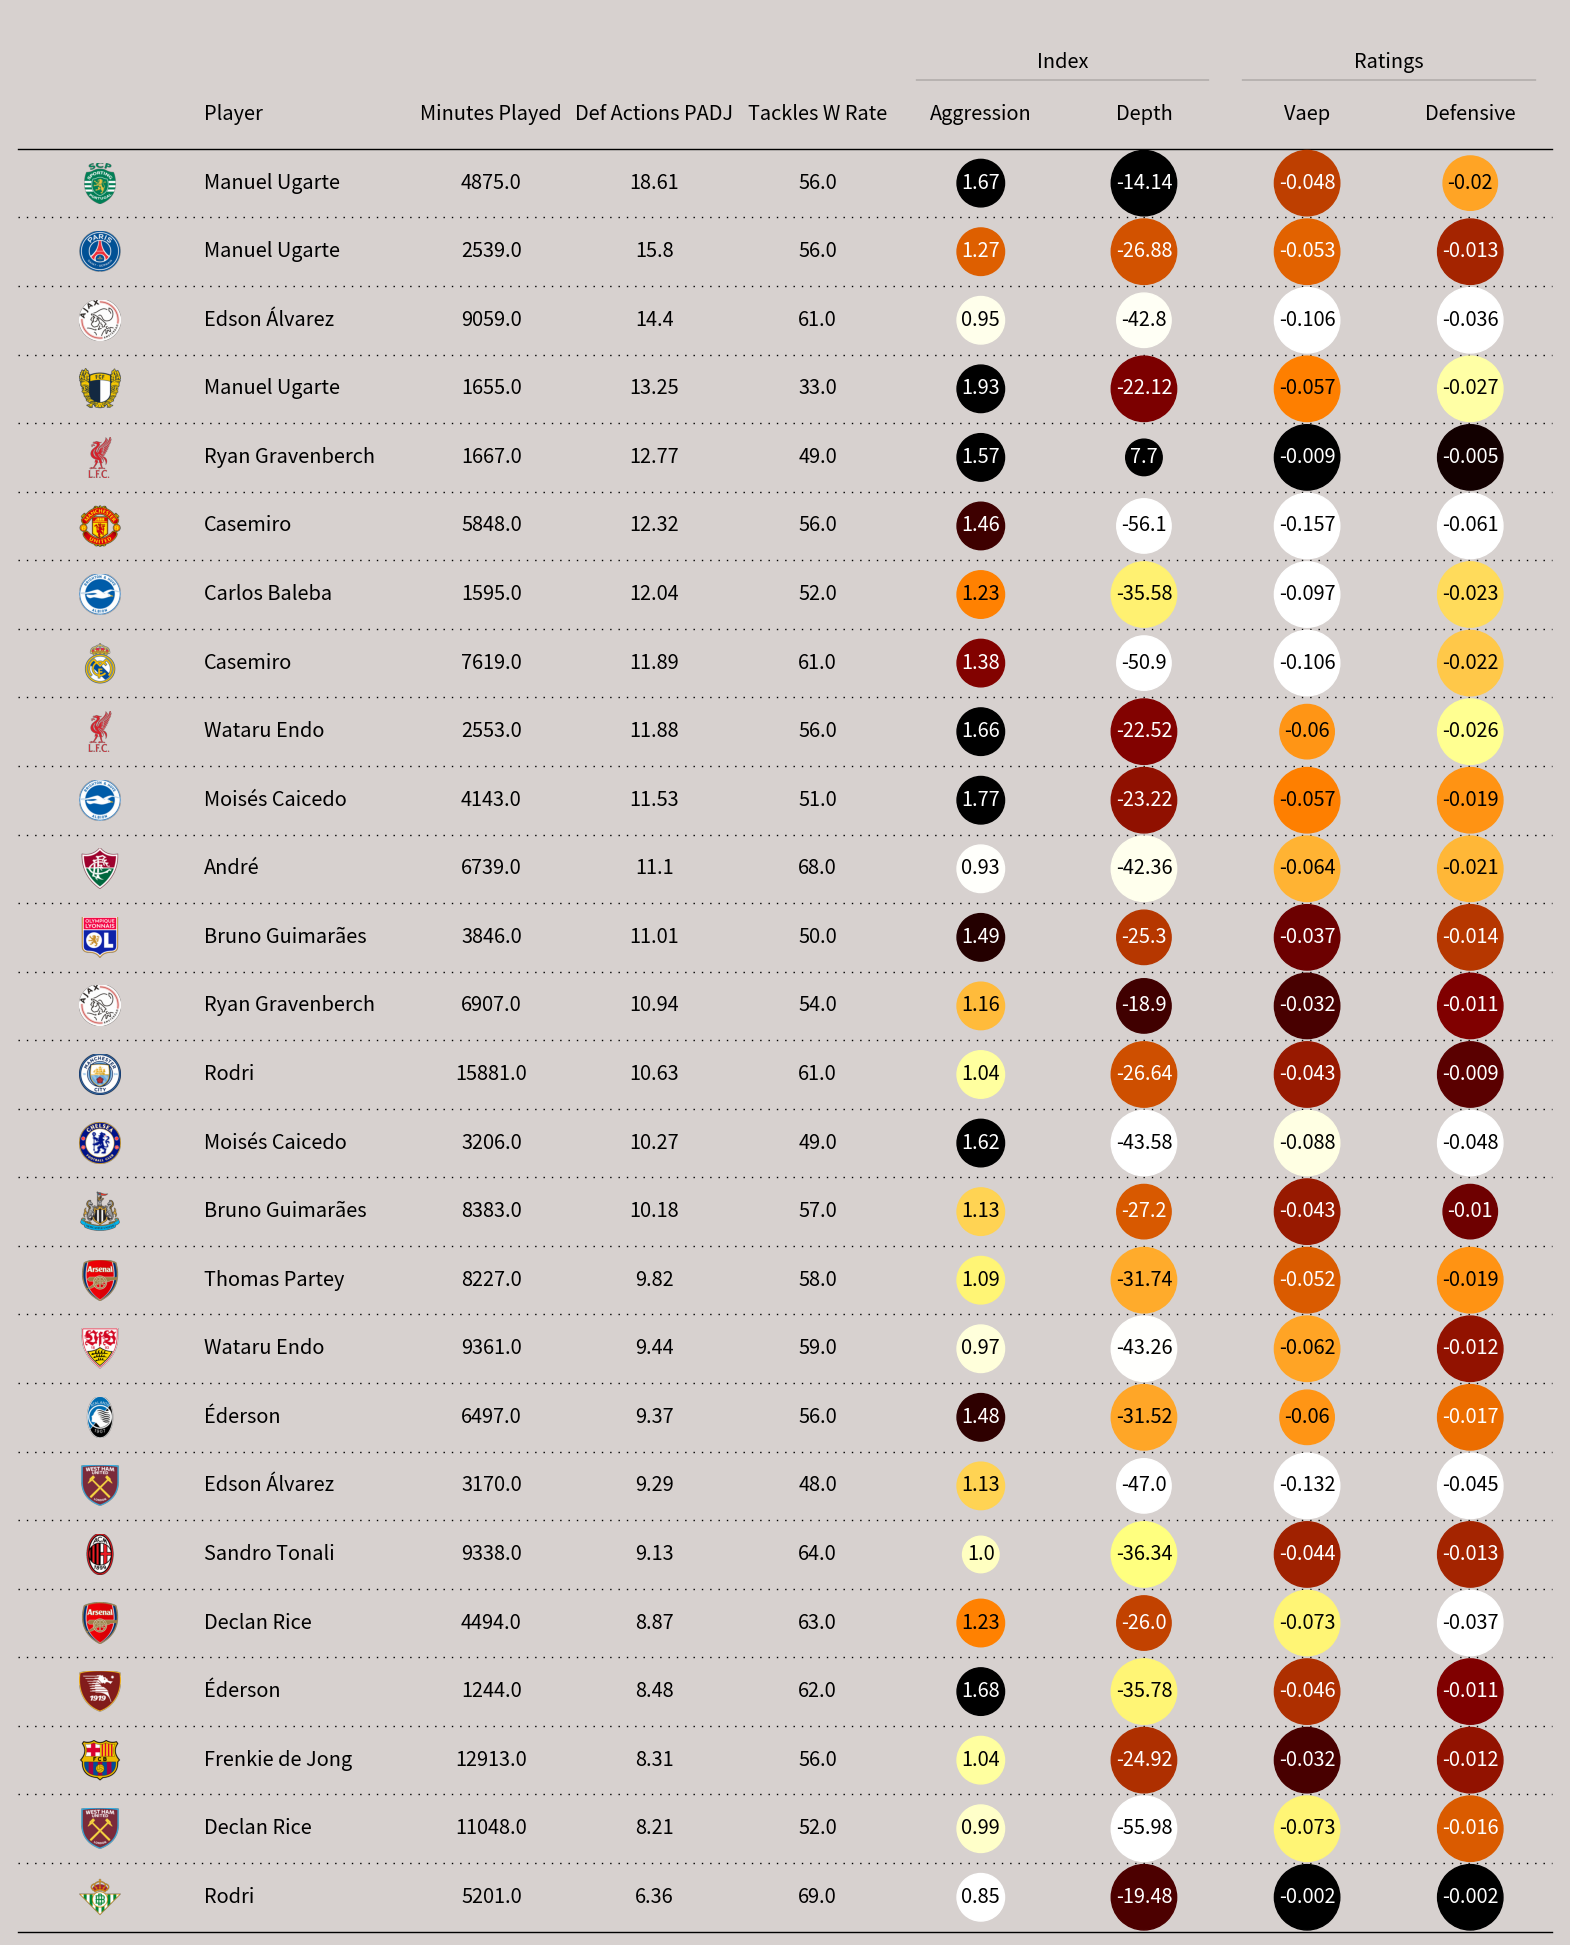

In [67]:
# Ok lets actually create the table
fig, ax = plt.subplots(figsize=(20, 25))
fig.set_facecolor("#D7D1CF")
ax.set_facecolor("#D7D1CF")
table = Table(
    CC,
    column_definitions=col_defs,
    index_col="fotmob_id",
    row_dividers=True,
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    footer_divider=True,
    textprops={"fontsize": 16},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": .5, "linestyle": "-"},
    ax=ax,
).autoset_fontcolors() # This will set the font color of the columns based on the cmap so the text is readable

table.cells[10, 3].textprops["color"] = "#8ACB88"

fig.savefig(f'defensiveactionstable.png', dpi=500, bbox_inches="tight")
fig.show()